In [4]:
def Bloch_vector(vec):         # return the Bloch vector of the current state
        r1 = np.absolute(vec[0])
        f1 = np.angle(vec[0])
        #r2 = np.absolute(vec[1])
        f2 = np.angle(vec[1])
        fi = f2 - f1
        theta = np.arccos(r1)*2
        return np.array([np.sin(theta)*np.cos(fi),np.sin(theta)*np.sin(fi),np.cos(theta)])

In [5]:
import numpy as np
from scipy import linalg as LA
import matplotlib.pyplot as plt
from gym import spaces
import qutip
import stable_baselines3
from stable_baselines3.ppo.policies import MlpPolicy
from stable_baselines3 import PPO

data_type=np.complex128

S_z = np.diag([1.,-1.]).astype(data_type)
S_x =np.array([[0.,1.],[1.,0.]],dtype=data_type)
S_y=np.array([[0.,complex(0,-1.)],[complex(0,1.),0.]],dtype=data_type) #Pauli Matrices
Sigma = np.array([S_x,S_y,S_z])

phi_final = np.array([1.+0j,0.+0j],dtype = data_type)                  # final state
phi_final /= LA.norm(phi_final)

phi_initial = np.array([0.+0j,0.+1.j],dtype= data_type)                # initial state
phi_initial /= LA.norm(phi_initial)

h_drift = np.array([0.33,0.33,0.33],dtype= np.float32)                 # drift Hamiltonian
dt = 0.5                                                               # time step
random = False                                                         # random or deterministic initial state

N_timesteps = 2048*200                                                 # number of timesteps in the learning process
ep_steps = 19                                                          # number of timesteps per episode

class  two_level_system:                                                # define the system
    def __init__(self,init_state,final_state,h_drift,ep_steps,N_timesteps,random):     # initialize the environment
        alpha = np.angle(init_state[0]) 
        self.state = init_state                                                        # convert the complex state to the NN state
        intermidiate = np.exp(-1j*alpha) * init_state
        self.nn_state = np.array([intermidiate[0].real,intermidiate[1].real,intermidiate[1].imag])
        self.init_state = init_state
        self.final_state = final_state
        
        self.ep_steps = ep_steps
        self.counter = 0
        self.h_drift = h_drift
        self.metadata = {}
        self.reward_range = (0.,1.)
        self.sigma_0 = np.eye(2, dtype= data_type)                                     
        self.random = random

        self.steps = 0
        self.rewards = np.zeros(N_timesteps)

        self.action_space = spaces.Box(low=-1.0, high= 1.0, shape=(3,) , dtype = np.float32)
        self.observation_space = spaces.Box(low=-1., high= 1., shape= (3,) , dtype= np.float32)
  
    def step(self, action, dt = dt, Sigma = Sigma):         # take a step in the environment
        
        a = LA.norm(self.h_drift+action)                    # get norm of the action + drift
        n = ((self.h_drift+action).astype(data_type))/a
        
        Unitary = self.sigma_0*np.cos(a*dt)+1j*(np.einsum("i,ijk->jk",n,Sigma))*np.sin(a*(-dt))     # compute the unitary operator
        
        self.state = Unitary @ self.state                                             # apply the unitary operator
        self.Complex_to_NN()                                        # convert the complex state to the NN state

        if self.counter < self.ep_steps:                             # check if the episode is finished
          Finish = False
        else:
          Finish = True
        
        if self.steps < N_timesteps:                                # add current reward to the reward array
         self.rewards[self.steps] = self.reward()
         self.steps += 1
        
        self.counter += 1                                               # increase the counter
        return self.nn_state.copy(),self.reward(),Finish,{}

    def reset(self):              # reset the state of the environment to an initial state
        if self.random :
         ini = np.random.normal(0,1,(4,))                      # generate a random initial state
         init = np.array([ini[0]+1j*ini[1],ini[2]+1j*ini[3]],dtype = np.complex128)      # convert the random state to complex state
         init /= LA.norm(init)
         self.state = init
         self.Complex_to_NN()
        
         self.counter = 0
         return self.nn_state.copy()
        else :
         self.state = self.init_state
         self.Complex_to_NN()
        
         self.counter = 0
         
         return self.nn_state.copy()

    def reward(self):              # compute the reward of the current state
        rew = np.vdot(self.state,self.final_state)
        reward = (rew*np.conj(rew)).real
        return reward

    def Complex_to_NN(self):    # convert the complex state to the angle state
        alpha = np.angle(self.state[0])
        intermidiate = np.exp(-1j*alpha) * self.state
        self.nn_state = np.array([intermidiate[0].real,intermidiate[1].real,intermidiate[1].imag], dtype = np.float32)

two_level = two_level_system(phi_initial,phi_final,h_drift,ep_steps,N_timesteps,random)


In [139]:
model = PPO("MlpPolicy", two_level,learning_rate = 0.001,seed = 0)
model.learn(total_timesteps = N_timesteps)

model.save("PPO_2_Level_system")

Step  1
Reward  0.5985710680112168
State  [0.52783186-0.56565413j 0.28495356+0.56588907j]
NN State  [ 0.7736738  -0.21933009  0.59441006]
Action  [ 0.91107005  1.         -1.        ]
Step  2
Reward  0.819361016829731
State  [0.65644564-0.62324966j 0.40917452-0.1149574j ]
NN State  [0.90518564 0.37588754 0.19836219]
Action  [ 0.49653345  0.6458374  -1.        ]
Step  3
Reward  0.977792576010395
State  [0.33207299-0.93140759j 0.12246775+0.08490649j]
NN State  [ 0.98883396 -0.03884809  0.143869  ]
Action  [ 0.11596443 -0.78569925  0.62862206]
Step  4
Reward  0.9992079189079193
State  [0.54288581-0.83933481j 0.01992039+0.01988223j]
NN State  [ 0.99960387 -0.00587568  0.02752456]
Action  [-0.07971179 -0.34441185 -0.7875395 ]
Step  5
Reward  0.9984898333964258
State  [ 0.51147507-0.85841895j -0.01914615+0.03381768j]
NN State  [ 9.9924463e-01 -3.8851865e-02  8.6213689e-04]
Action  [-0.28001404 -0.39383274 -0.25440338]
Step  6
Reward  0.9994989608661189
State  [ 0.52044836-0.85359971j -0.0078

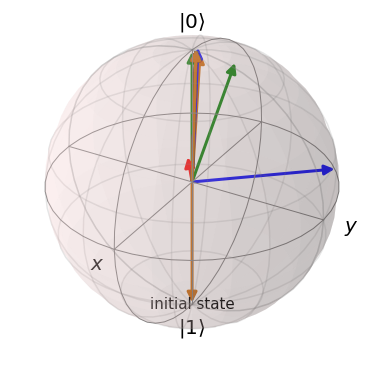

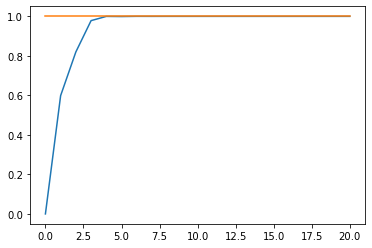

In [162]:
best = PPO.load("PPO_2_Level_fixed_initial_state")

obs = two_level.reset()
rewards = []
rewards.append(two_level.reward())
b = qutip.Bloch()                    # initialize the Bloch sphere

final = Bloch_vector(phi_final)      # convert the final state to the Bloch vector
b.add_vectors(final)                 # add the final state to the Bloch sphere


start  = Bloch_vector(two_level.state)
b.add_annotation(start,text = 'initial state', fontsize = 15)       # add label to the initial state   
b.add_vectors(start)                                    # add the initial state to the Bloch sphere


j=0
done = False
while not done:                                      # run the optimal episode
    action, _states = best.predict(obs,deterministic= True)
    obs, reward, done, info = two_level.step(action)
    j+=1
    b.add_vectors(Bloch_vector(two_level.state))
    rewards.append(reward)
    print("Step ",j)
    print("Reward ",reward)
    print("State ",two_level.state)
    print("NN State ",two_level.nn_state)
    print("Action ",action)
    #print("\n")

b.render()
b.show()
plt.plot(np.arange(len(rewards)),rewards,np.arange(len(rewards)),np.ones(len(rewards)))
plt.show()
b.clear()

4096


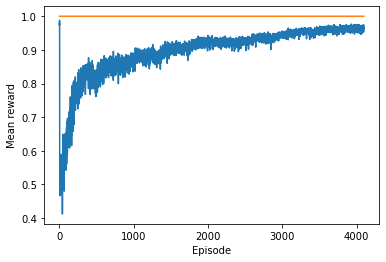

In [140]:
learning_reward = np.array(two_level.rewards)               # get the learning reward
learning_reward = learning_reward.reshape(-1,100)


mean_reward = np.mean(np.array(learning_reward).reshape(-1,100),axis = 1)

mean_reward = mean_reward.reshape(-1)                       # get the mean reward
x = np.arange(len(mean_reward))
print(len(x))

#w,v,a,b,c,d = np.polyfit(x,mean_reward,deg = 5)
plt.plot(x,mean_reward,x,np.ones(len(x)))                  # plot the mean reward
    
plt.xlabel("Episode")
plt.ylabel("Mean reward")
plt.show()

In [149]:
stad = best.get_parameters()              # get the policy parameters
stad = stad["policy"]["log_std"]
print(stad)

tensor([-1.7343, -1.2756,  0.1420])


In [126]:
random = True                    # Evaluate policy, changing the parameters random switches from deterministic to stochastic
stable_baselines3.common.evaluation.evaluate_policy(best, two_level, n_eval_episodes=10, deterministic=True,return_episode_rewards=True)

([19.93269830942154,
  19.504128217697144,
  19.511902272701263,
  19.086387634277344,
  19.802589118480682,
  19.471874356269836,
  18.7722128033638,
  19.70486068725586,
  19.849307119846344,
  19.511281609535217],
 [20, 20, 20, 20, 20, 20, 20, 20, 20, 20])